# Deep-Significance - Significance Testing
Docs: https://deep-significance.readthedocs.io/en/latest/

We are using *Almost Stochastic Order* (ASO) test.

> <cite> Dror, R., Shlomov, S., & Reichart, R. (2019, July). Deep Dominance - how to properly compare deep neural models. In Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics (pp. 2773-2785).

![logo](https://deep-significance.readthedocs.io/en/latest/_images/logo.png)


Installation: 

`pip install deepsig`

In [22]:
import numpy as np
from deepsig import aso
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# set random seed
seed = 1234
np.random.seed(seed)

## Statistical Hypothesis Testing

Let $S_A$ and $S_B$ the sets of scores of running two models $A$ and $B$

### Simulate scores

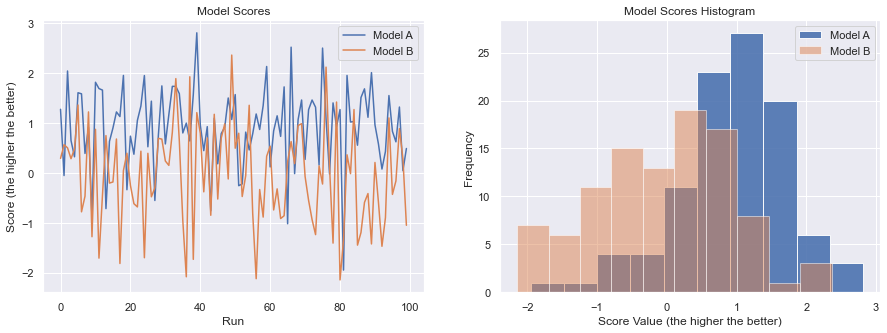

In [23]:
N = 100  # Number of runs

# loc   --> mean
# scale --> stdv
model_A = np.random.normal(loc=0.9, scale=0.8, size=N)
model_B = np.random.normal(loc=0, scale=1, size=N)

def plot_model_scores(model_A, model_B):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(model_A, label = "Model A")
    plt.plot(model_B, label = "Model B")
    plt.ylabel("Score (the higher the better)")
    plt.xlabel("Run")
    plt.title("Model Scores")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(model_A, label = "Model A", alpha = 0.9)
    plt.hist(model_B, label = "Model B", alpha = 0.5)
    plt.ylabel("Frequency")
    plt.xlabel("Score Value (the higher the better)")
    plt.title("Model Scores Histogram")
    plt.legend()
    plt.show()

plot_model_scores(model_A, model_B)

# Background
## Using *p-values*

Then, we can define a one-sided test statistic:

$$
\delta(S_A, S_B)
$$

Next, we formulate the following null-hypothesis

$$
H_0: \delta(S_A, S_B) \leq 0
$$


This means, assuming A is not better than B, but equally as good or worse. (No difference)

So, if we repeat the experiment again using the same conditions, the ***p_value*** is the probability that, under the null hypothesis, the test statistic is large than or equal to the **observed** test statistic.

$$
p(\delta(S_A^{rep}, S_B^{rep}) \geq \delta(S_A, S_B) | H_0 )
$$

Thus, 
- if the p-value is high we cannot reject $H_0$, A is not better than B
- if the p-value is low we can reject $H_0$, hence A is better than B

Generally, a threshold is set to $\alpha = 0.05$ that the ***p-value*** has to fall below to reject $H_0$

## Stochastic Order: Compare CDF

If the CDF of A is lower than B for every $x$, we know the algorithm A to score higher.
Given that CDF is the probability that $X$ will take a value less than or equal to $x$

$$
F_x(x) = P(X \leq x)
$$

We can declare one as ***stochastically dominant*** by comparing their cumulative distribution functions

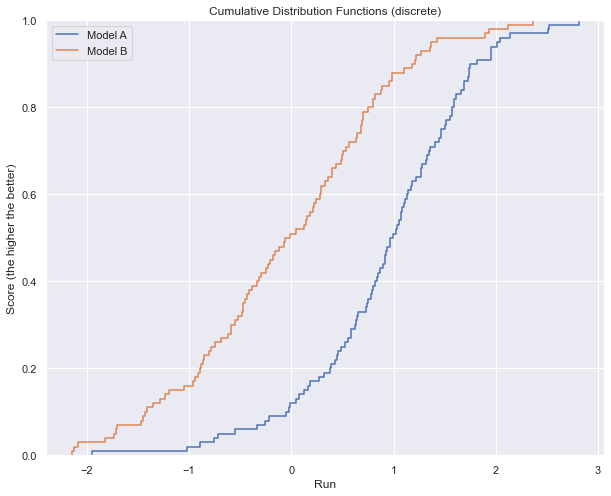

In [24]:
import pandas as  pd

df = pd.DataFrame({
    'Model A': model_A,
    'Model B': model_B,
})

plt.figure(figsize=(10, 8))
sns.ecdfplot(data = df)
plt.ylabel("Score (the higher the better)")
plt.xlabel("Run")
plt.title("Cumulative Distribution Functions (discrete)")
plt.show()

### Drawback:

Example: Two normal distributions with the same mean but different variances

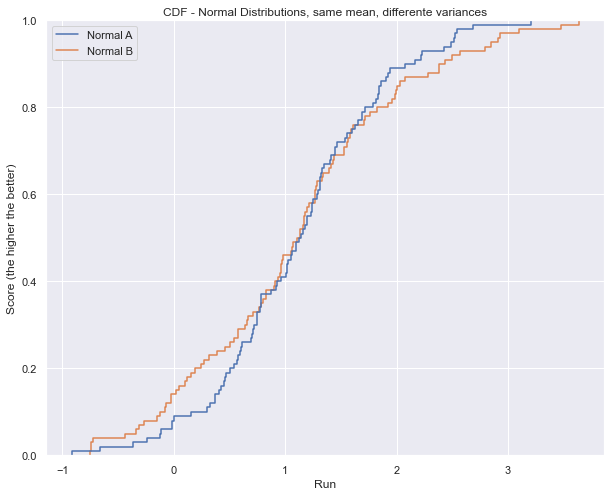

In [25]:
normal_1 = np.random.normal(loc=1, scale=0.8, size=N)
normal_2 = np.random.normal(loc=1, scale=1, size=N)

df = pd.DataFrame({
    'Normal A': normal_1,
    'Normal B': normal_2,
})

plt.figure(figsize=(10, 8))
sns.ecdfplot(data = df)
plt.ylabel("Score (the higher the better)")
plt.xlabel("Run")
plt.title("CDF - Normal Distributions, same mean, differente variances")
plt.show()

**For this, *Almost Stochastic Dominance* by quantifying the extent to which stochastic order is being violated.**

## Almost Stochastic Order Test - A test to compare two score distributions
ASO return a value $\epsilon_{min}$ that expresses an upper bound to the amount of violation of stochastic order. It can be seen as confidence score, the lower it is, the more sure we can be that A is better than B.

ASO does not compute p-values, instead the null hypothesis formulated as
$$
H_0: \epsilon_{min} < \tau,
$$

where $\tau$ is 0.5

# Scenario 1 - Comparing multiple runs of two models

Test model A is better than model B (the higher the better). 

-  ASO does not make any assumptions about the distributions of scores. 
  
- We can apply it as long as a higher score indicates a better performance. **Multiple by -1 for lower scores**
- The more scores are supplied, the more reliable the test becomes

In [26]:
min_eps = aso(model_A, model_B, seed=seed, confidence_level = 0.95)

Bootstrap iterations: 100%|█████████▉| 999/1000 [00:14<00:00, 67.05it/s]


if `min_eps` < 0.5 then A is better than B (higher scores)

In [27]:
print("Rejection threshold: < 0.5")
print(f"Min Eps: {np.round(min_eps, 3)}, we cant reject H0, so Model A is better")

Rejection threshold: < 0.5
Min Eps: 0.001, we cant reject H0, so Model A is better


# Scenario 2 - Comparing multiple runs across datasets

- We can formulate one null hypothesis per dataset.
- We have to make sure not to fall prey to the ***multiple comparisons problem***
  - The more inferences are made, the more likely erroneous inferences become
  - Coincidence example (image)
- We have to adjust our significance threshold $\alpha$ accordingly by dividing it by the number of comparisons.
- Bonferroni correction $\alpha = \frac{\alpha}{n}$, where $n$ is the number of tests performed

![Example](https://miro.medium.com/max/1400/1*ERarZ75RoWF8Vn-_AlEmaA.jpeg)



In [28]:
# Simulate scores for three datasets
M = 3  # Number of datasets
N = 100  # Number of runs

model_A_datasets = [np.random.normal(loc=0.9, scale=0.8, size=N) for _ in range(M)]
model_B_datasets  = [np.random.normal(loc=0, scale=1, size=N) for _ in range(M)]

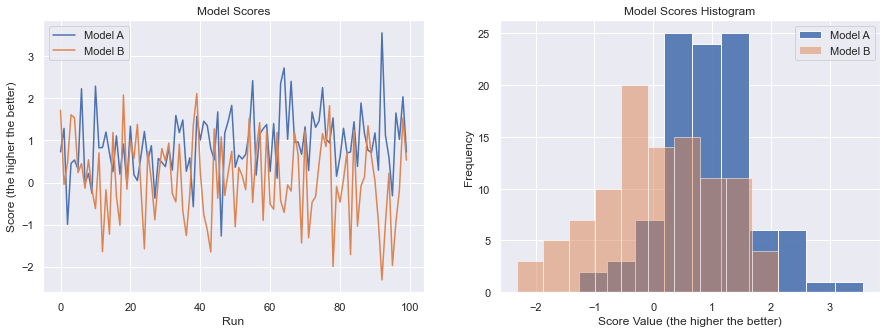

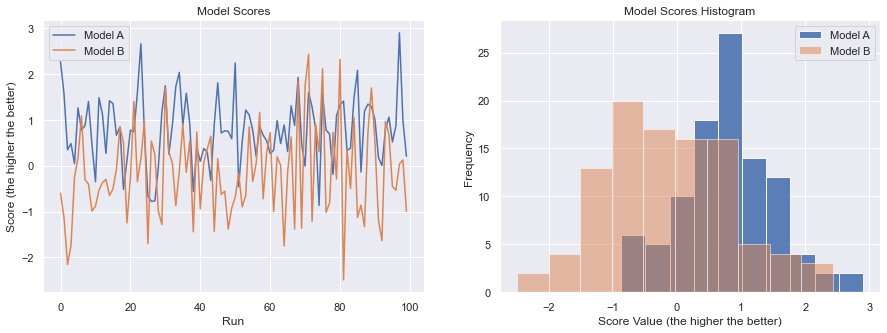

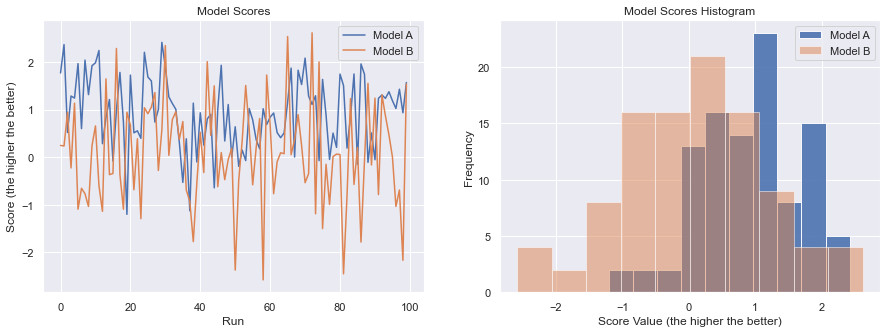

In [29]:
for model_A, model_B in zip(model_A_datasets, model_B_datasets):
    plot_model_scores(model_A, model_B)

In [30]:
# epsilon_min values with Bonferroni correction
eps_min = [
    aso(data_a, data_b, confidence_level=0.95, num_comparisons=M, seed=seed) 
        for data_a, data_b in zip(model_A_datasets, model_B_datasets)
]

Bootstrap iterations: 100%|█████████▉| 999/1000 [00:14<00:00, 69.46it/s]


In [31]:
print("Rejection threshold: < 0.5")
for i, eps in enumerate(eps_min):
    print(f"Min Eps in dataset {i}: {np.round(eps, 4)}, we cant reject H0, so Model A is better than B")

Rejection threshold: < 0.5
Min Eps in dataset 0: 0.0004, we cant reject H0, so Model A is better than B
Min Eps in dataset 1: 0.0037, we cant reject H0, so Model A is better than B
Min Eps in dataset 2: 0.0097, we cant reject H0, so Model A is better than B
